In [ ]:
# 1.install libs
!pip install --upgrade librosa
!pip install --upgrade tensorflow_addons
import tensorflow as tf
import numpy as np

from IPython.display import Audio, display
from tensorflow_addons.image import sparse_image_warp
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import copy
import math
import os

%matplotlib inline

In [2]:
# 2.mount gdrive
from google.colab import drive
drive.mount('/root/gdrive')
#!cp -r ./ColabData/YonaVox/ac_audio/*  ./ColabData/YonaVox/ac_audio1/
#in other google account should create shortcut to shared folder: /root/gdrive/.shortcut-targets-by-id/1dBbP3yvAtULEFTCfdX-ZlyuA19YbCpWp
!ln -s /root/gdrive/MyDrive/ColabData /content/
colab_data = "./ColabData/YonaVox/"
!ls /content/ColabData

Mounted at /root/gdrive
YonaVox


In [3]:
# 3.Load an audio file stored as WAV mono-channel, and decode it into a tensor
def load_audio_track(path):
    audio_binary = tf.io.read_file(path)
    audio_unsqueezed, sample_rate = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio_unsqueezed, axis=-1).numpy(), sample_rate.numpy()

#Create a dictionary where each key is the syllable uttered in the audio file stored as the value
def get_track_dict(track_dir):
    track_dict = {}
    for entry in os.listdir(track_dir):
        if entry.endswith(".wav"):
            syllable = entry.split(".")[0]
            sound_track, sample_rate = load_audio_track(track_dir + entry)
            track_dict[syllable] = sound_track

    return track_dict, sample_rate

#plot the waveform of the audio slice
def plot_waveform(audio_slice, figsize=(22, 4), *args, **kwargs):
  plt.figure(figsize=figsize)
  sns.set(style='darkgrid')
  sns.lineplot(data=audio_slice, *args, **kwargs)
  plt.show()

# Load the track dictionary and the background noise sample
track_dir = colab_data + "ac_audio/"
track_dict, sample_rate = get_track_dict(track_dir + "phrases/")
background_dict, _ = get_track_dict(track_dir + "background/")
background_noise, _ = load_audio_track(track_dir + "special/BKG.wav")

audio_slice_len = 2 * sample_rate
track_keys = list(track_dict.keys())
bkg_keys = list(background_dict.keys())
print(track_keys)
print(bkg_keys)

['gai4_ge1_qing3_hui2_da2', 'gai4_ge1_qing3_da2_hui2', 'gai4_ge1_hui2_qing3_da2', 'ge1_gai4_hui2_da2_qing3', 'ge1_gai4_da2_hui2_qing3', 'ge1_gai4_da2_qing3_hui2', 'UNK_gai4_UNK', 'UNK_ge1_UNK', 'UNK_qing3_UNK', 'UNK_hui2_UNK', 'UNK_da2_UNK', 'gai4', 'ge1', 'qing3', 'hui2', 'da2']
['Drum_Cover', 'Koto_Music', 'Linkin_Park_Karaoke', 'Meir_Banay', 'Einaudi_Oltremare', 'Prometheus_Theme', 'Rain_Noise', 'Silent_Noise', 'Static_Noise', 'Traffic_Noise', 'Yiruma_Piano']


In [ ]:
# Extract a 3-second audio slice and play it
audio_slice = track_dict[track_keys[8]][:7 * sample_rate]
print(audio_slice.shape)
display(Audio(audio_slice, rate=sample_rate))

#Then plot it's waveform, and some background noise below it
plot_waveform(audio_slice)
plot_waveform(background_noise[:7 * sample_rate])

In [4]:
# 4. Extracts all spoken phrases from a given audio slice
def extract_phrases(
    audio_slice, 
    max_phrases=None, 
    speech_volume=0.001, 
    min_uttered_samples=math.floor(0.25 * sample_rate), 
    max_silent_samples=math.floor(0.99 * sample_rate),
    start_window=math.floor(0.5 * sample_rate),
    end_window=math.floor(1.0 * sample_rate),
    trim_window=math.floor(0.9 * sample_rate),
    log=False
    ):
  
    if min_uttered_samples > end_window:
        raise Exception("End sliding window cannot be smaller than min_uttered_samples")
    if max_silent_samples > end_window:
        raise Exception("End sliding window cannot be smaller than max_silent_samples")
    if start_window > end_window:
        raise Exception("End sliding window cannot be smaller than start sliding window")

    padded_slice = np.pad(audio_slice, (0, end_window))
    phrases = []
    phrase = []
    loud_samples = 0
    silent_samples_in_end_frame = 0
    speech_start = False

    for amp_idx, amplitude in enumerate(padded_slice):
        #1) Determine if the sample amplitude is higher than abs(speech_volume), and classify it as loud/silent accordingly
        if amplitude < -speech_volume or speech_volume < amplitude:
            if log and not speech_start:
                print("speech start at idx {}".format(amp_idx))
            speech_start = True
            loud_samples += 1
        elif speech_start:
            silent_samples_in_end_frame += 1

        #2) If currently extracting a phrase (i.e. speech is detected), append the current sample as well
        if speech_start:
            phrase.append(amplitude)

        #3) If the current phrase has more samples than the size of end_window, decrement the relevant counters
        if len(phrase) > end_window:
            lagged_idx = len(phrase) - end_window
            lagged_amp = phrase[lagged_idx]
            
            if silent_samples_in_end_frame > 0 and (-speech_volume <= lagged_amp and lagged_amp <= speech_volume): #a silent sample is leaving the window
                silent_samples_in_end_frame -= 1
        
        #4) If the current phrase has more samples than the size of start_window, decrement the relevant counters
        # If the signal does not contain enough speech, pop the earliest sample from the signal start
        if len(phrase) > start_window and loud_samples < min_uttered_samples:
            lagged_amp = phrase.pop(0)
            if loud_samples > 0 and (lagged_amp < -speech_volume or speech_volume < lagged_amp): #a loud sample is leaving the window
                loud_samples -= 1
            if silent_samples_in_end_frame > 0 and (-speech_volume <= lagged_amp and lagged_amp <= speech_volume): #a silent sample is leaving the window
                silent_samples_in_end_frame -= 1

        # Log counters if logging is enabled
        if log and amp_idx % 500 == 0:
            print("samples for frame {}".format(amp_idx))
            print("loud_samples: {}".format(loud_samples))
            print("silent_samples_in_end_frame: {}".format(silent_samples_in_end_frame))
            print("\n")

        #5) If the phrase has been extracted, append it to the phrases list and reset the counters
        if silent_samples_in_end_frame >= max_silent_samples or (amp_idx + 1) == len(padded_slice):
            if loud_samples >= min_uttered_samples:
                trim_idx = min(len(phrase)-trim_window, audio_slice_len)
                if log:
                    print("speech end at idx {}".format(amp_idx)) 
                    print("len(phrase) {}".format(len(phrase))) 
                    print("trim_idx {}".format(trim_idx)) 
                
                phrases.append(np.array(phrase[:trim_idx]))
                if max_phrases is not None and len(phrases) >= max_phrases:
                    return np.array(phrases)
            elif log:
                print("speech cancel at idx {}".format(amp_idx))
            
            if log:
                print("clearing phrase data...")

            phrase = []
            loud_samples = 0        
            silent_samples_in_end_frame = 0
            speech_start = False

    return np.array(phrases, dtype=object)

#Extract the first syllable from each sound file, and store in the same key-value form used for track_dict
first_phrases = {phrase:extract_phrases(audio, max_phrases=1)[0] for (phrase, audio) in track_dict.items()}

<ipython-input-4-8dd3f47504e0>:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(phrases)


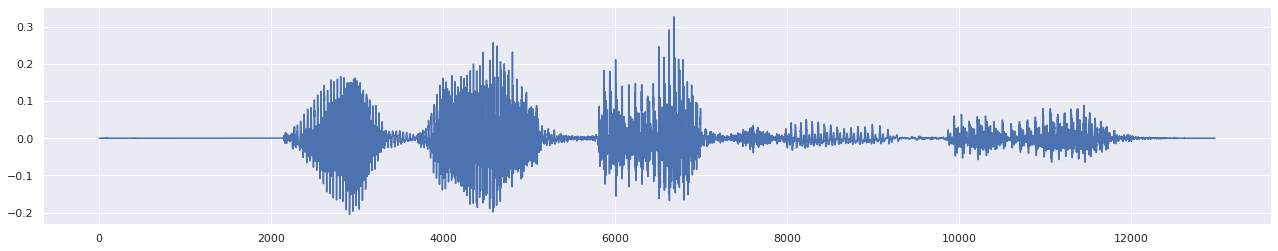

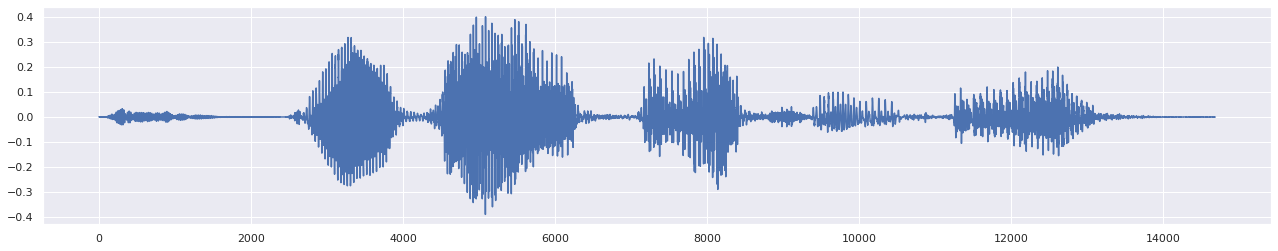

In [ ]:
#Test the extraction algorithm to verify it extracts whole utterances
tk = "ge1_gai4_da2_qing3_hui2"
test_phrases = extract_phrases(track_dict[tk], max_phrases=50, log=False)

plot_waveform(test_phrases[0])
display(Audio(test_phrases[0], rate=sample_rate))
plot_waveform(test_phrases[49])
display(Audio(test_phrases[49], rate=sample_rate))

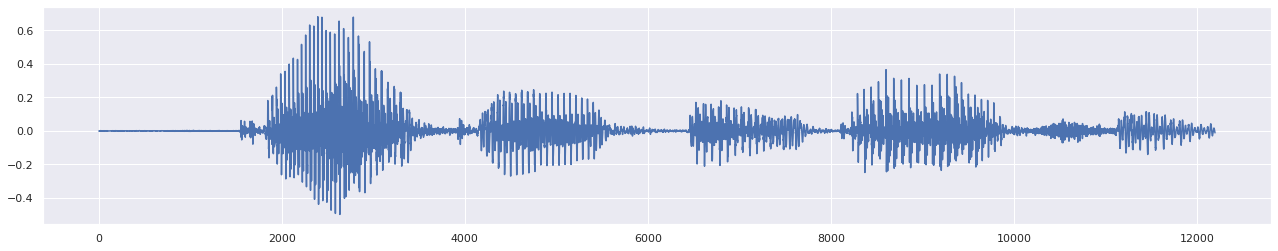

BKG_gai4_ge1_hui2_da2_qing3_BKG


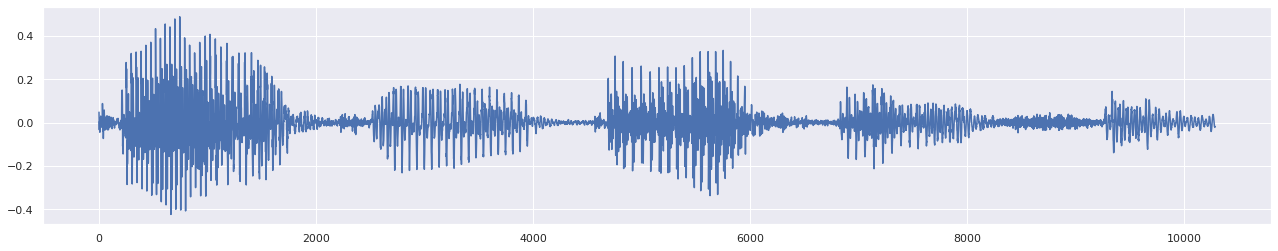

BKG_gai4_ge1_da2_hui2_qing3_BKG


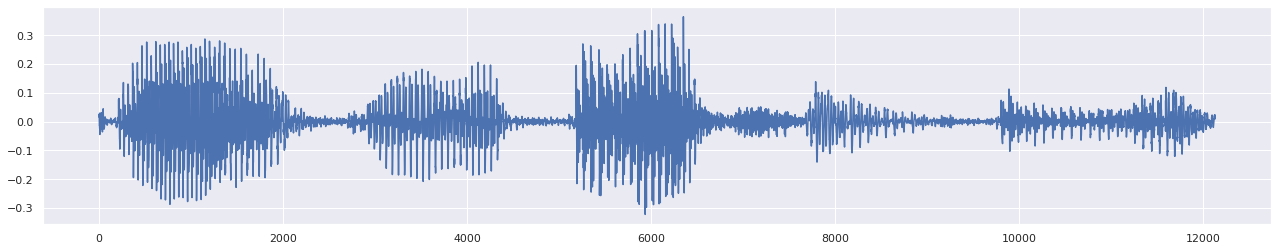

BKG_gai4_ge1_da2_qing3_hui2_BKG


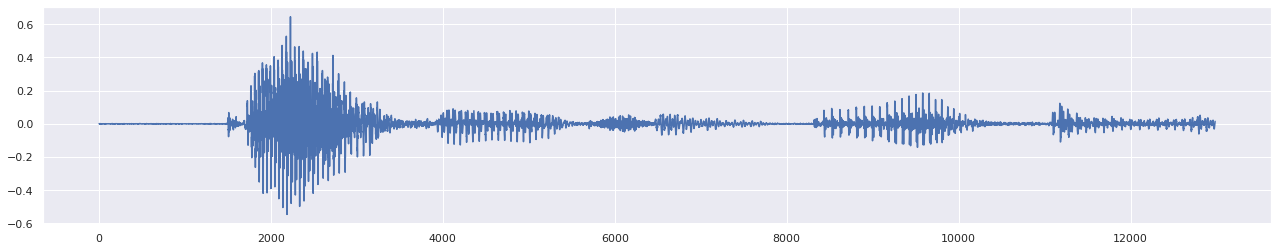

BKG_gai4_ge1_qing3_da2_hui2_BKG


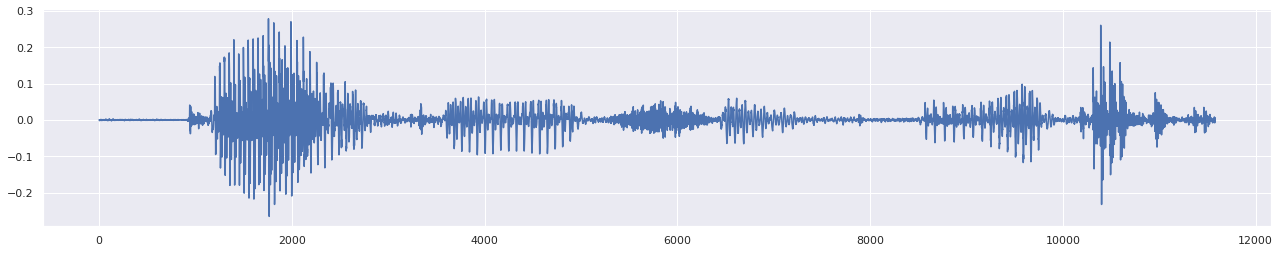

BKG_gai4_ge1_qing3_hui2_da2_BKG


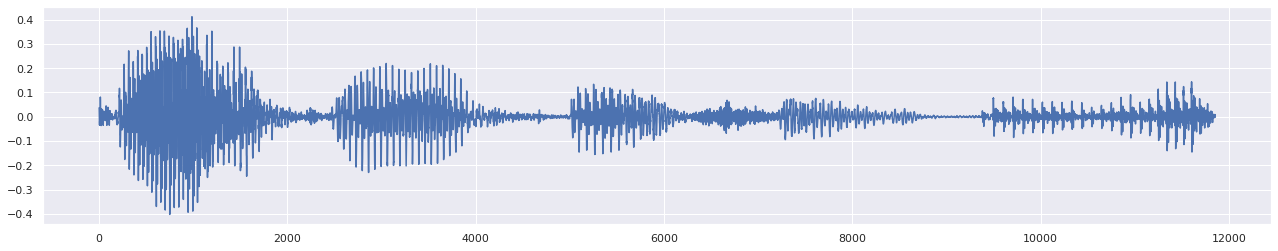

BKG_gai4_ge1_hui2_qing3_da2_BKG


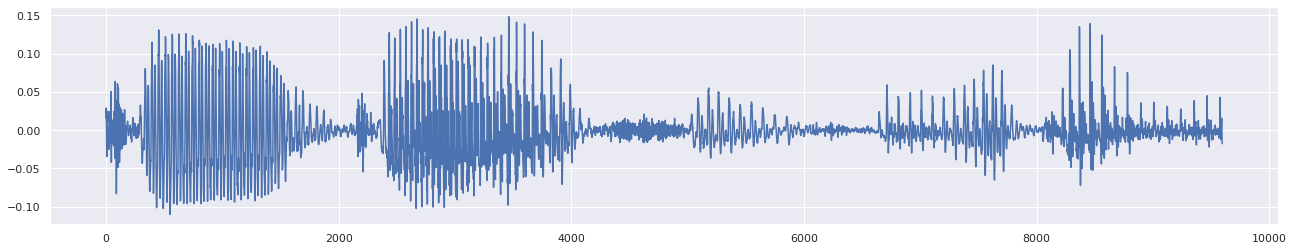

BKG_ge1_gai4_qing3_hui2_da2_BKG


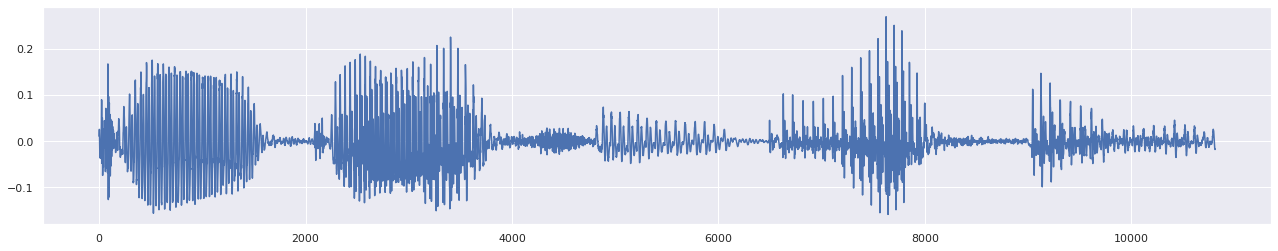

BKG_ge1_gai4_qing3_da2_hui2_BKG


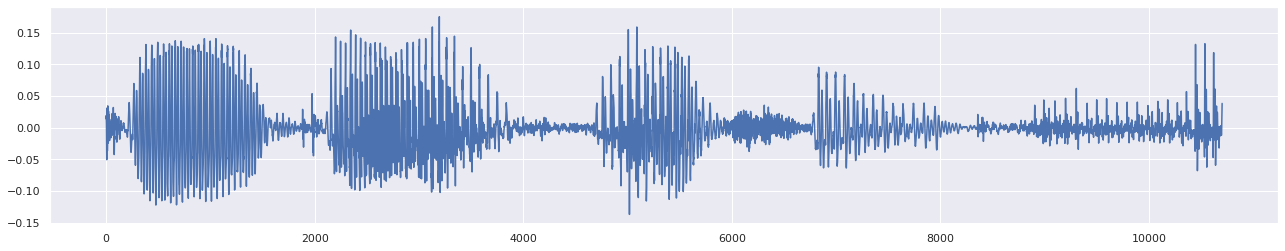

BKG_ge1_gai4_hui2_qing3_da2_BKG


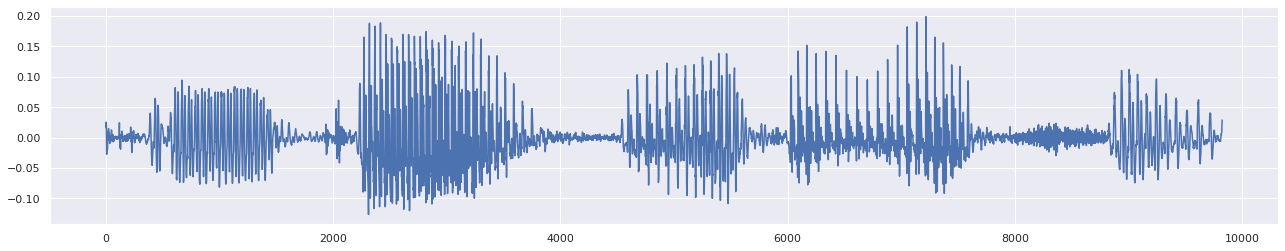

BKG_ge1_gai4_hui2_da2_qing3_BKG


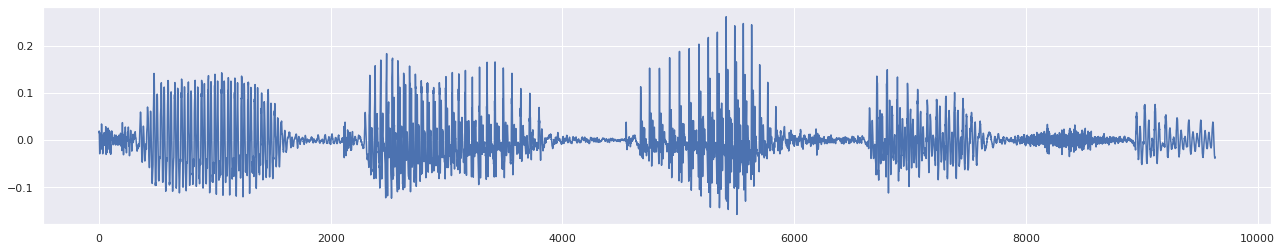

BKG_ge1_gai4_da2_hui2_qing3_BKG


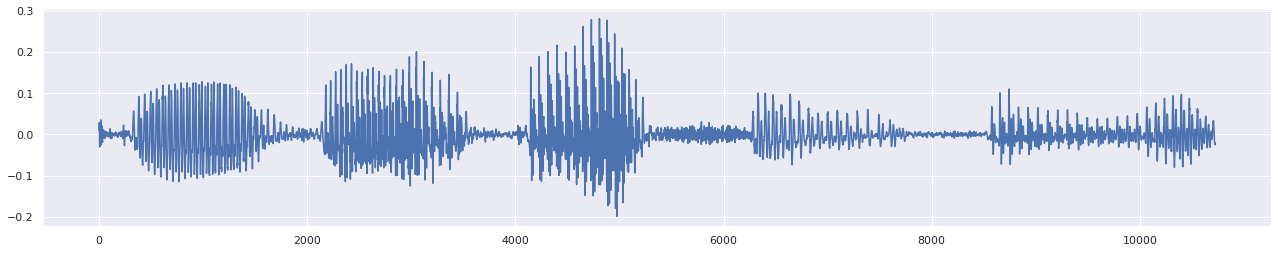

BKG_ge1_gai4_da2_qing3_hui2_BKG


In [ ]:
# Plot the first utterance in every track + matching audio, for sanity checking
for track_key in track_keys:
    plot_waveform(first_phrases[track_key])
    print(track_key)
    display(Audio(first_phrases[track_key], rate=sample_rate))

In [5]:
# 5.Extract all utterances from each sound file, and store in the same key-value form used for track_dict
#need 4 minutes
phrase_map = {phrase:extract_phrases(audio, max_phrases=50) for (phrase, audio) in track_dict.items()}

<ipython-input-4-8dd3f47504e0>:77: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(phrases)


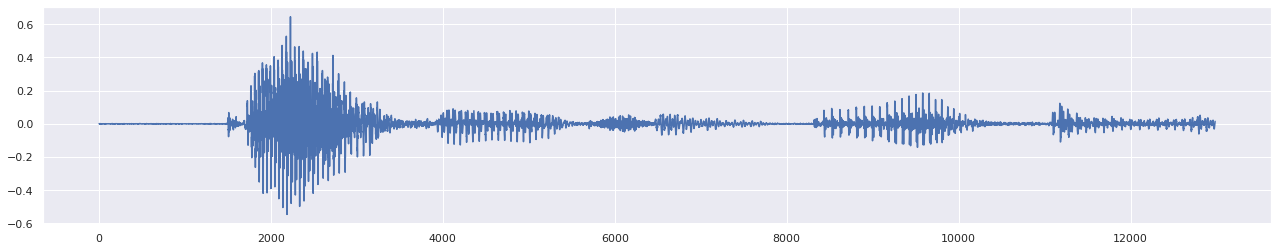

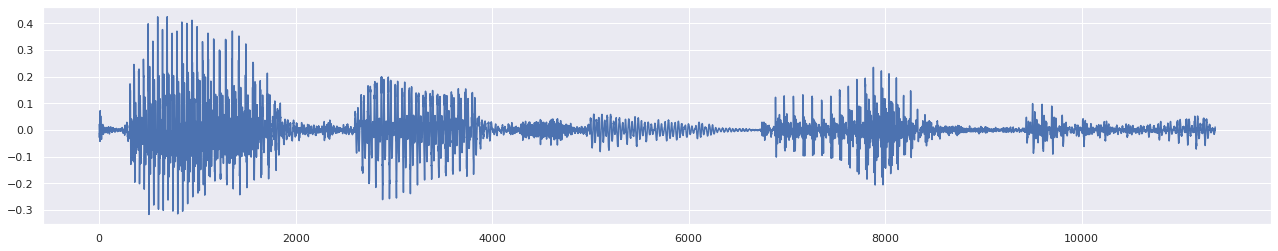

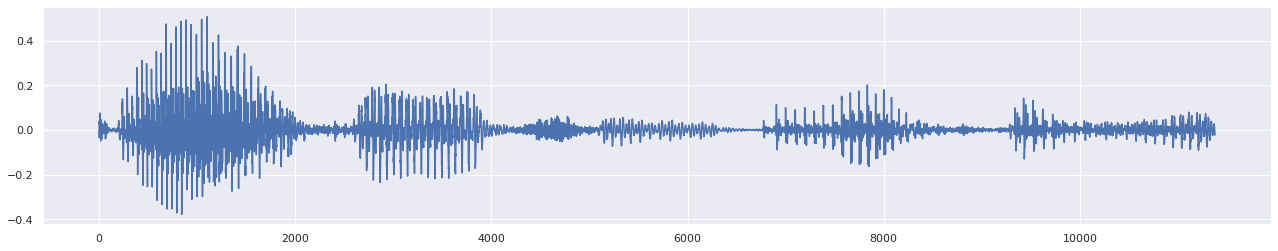

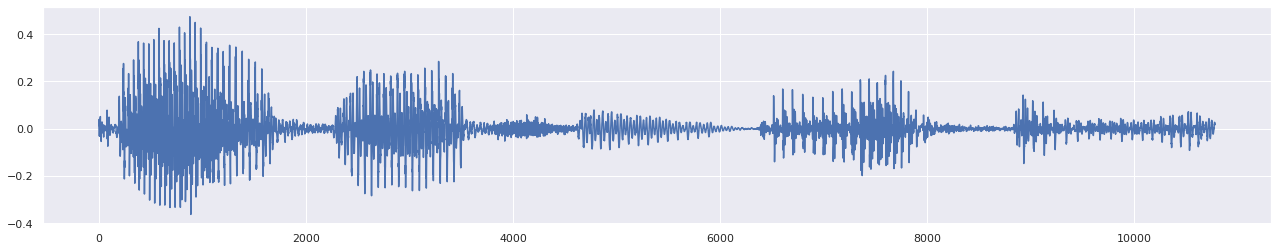

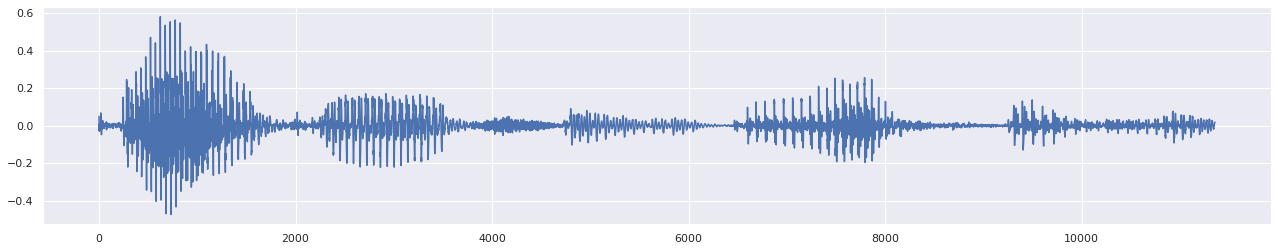

BKG_gai4_ge1_hui2_da2_qing3_BKG
1: length 12200, at timestamp 0
2: length 10990, at timestamp 12200
3: length 10697, at timestamp 23190
4: length 10729, at timestamp 33887
5: length 10706, at timestamp 44616
BKG_gai4_ge1_da2_hui2_qing3_BKG
1: length 10285, at timestamp 0
2: length 10238, at timestamp 10285
3: length 10462, at timestamp 20523
4: length 10528, at timestamp 30985
5: length 10417, at timestamp 41513
BKG_gai4_ge1_da2_qing3_hui2_BKG
1: length 12134, at timestamp 0
2: length 11790, at timestamp 12134
3: length 11431, at timestamp 23924
4: length 11266, at timestamp 35355
5: length 11720, at timestamp 46621
BKG_gai4_ge1_qing3_da2_hui2_BKG
1: length 12985, at timestamp 0
2: length 11359, at timestamp 12985
3: length 11378, at timestamp 24344
4: length 10782, at timestamp 35722
5: length 11358, at timestamp 46504
BKG_gai4_ge1_qing3_hui2_da2_BKG
1: length 11580, at timestamp 0
2: length 10169, at timestamp 11580
3: length 10278, at timestamp 21749
4: length 10597, at timestamp 32

In [ ]:
# Plot the first five utterances(phrases) in a single track + matching audio, for sanity checking
tptest_phraseh = phrase_map["BKG_gai4_ge1_qing3_da2_hui2_BKG"]
for i in range(5):
    plot_waveform(tptest_phraseh[i])
    display(Audio(tptest_phraseh[i], rate=sample_rate))

# Plot the length of each extracted utterance, grouped by what was actually said (i.e. tracks with the same phrase spoekn are grouped together) 
# Ideally, identical phrases should be of the same length. Phrases that are too long/short probably indicate bad extractions
# There might still be room for improvement on the data and the extraction algorithm, but let's start with this
for (phrase, vals) in phrase_map.items():
    timestamp = 0
    print(phrase)
    for idx, wvf in enumerate(vals):
        print("{}: length {}, at timestamp {}".format(idx+1, len(wvf), timestamp))
        timestamp += len(wvf)

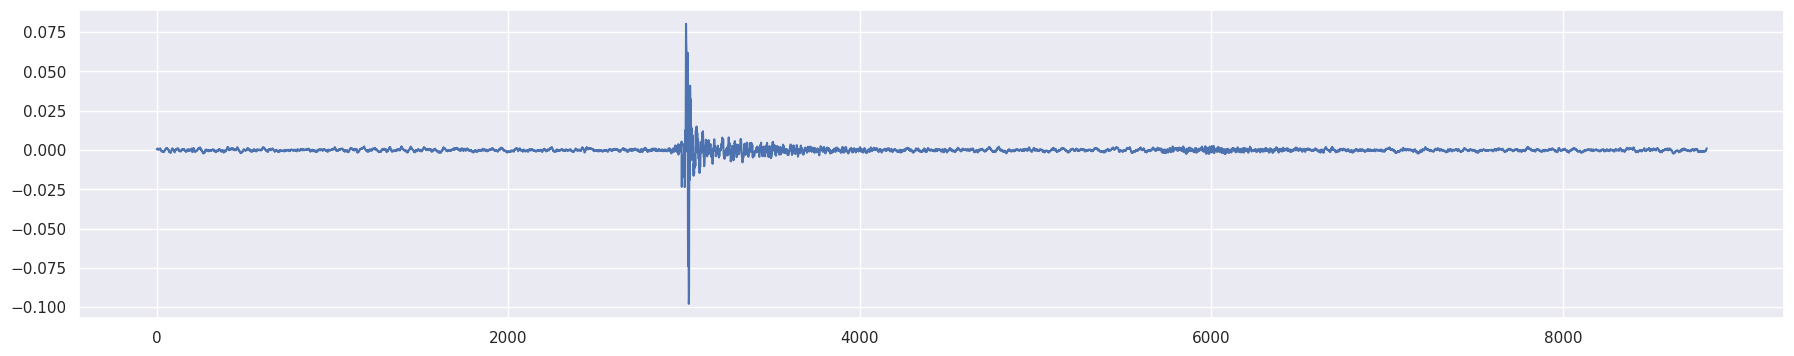

In [6]:
# 6. Extract random slices from the provided waveform audio
def extract_random_slices(audio, slice_count, total_samples=sample_rate):
    starting_points = max(slice_count - 1, 0)
    random_points = np.floor(np.random.rand(starting_points) * total_samples).astype(np.int32)
    random_shift = math.floor(np.random.rand() * (len(audio) - total_samples))
    sorted_points = np.sort(random_points)

    start_points = np.insert(sorted_points, 0, 0)  + random_shift
    end_points = np.append(sorted_points, total_samples)  + random_shift

    slices = []
    for i in range(slice_count):
        start_idx = start_points[i]
        end_idx = end_points[i]
        random_slice = audio[start_idx:end_idx]
        slices.append(np.array(random_slice))

    return slices

#Extract and plot slices of background noise
bg_noise_slices = extract_random_slices(background_noise, 3)

noise_concat = np.concatenate(bg_noise_slices)
plot_waveform(noise_concat)
display(Audio(noise_concat, rate=sample_rate))

<ipython-input-7-74e554d82fbd>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  noise_slices = np.array(extract_random_slices(background_noise, slice_count=2, total_samples=noise_samples))


764
2166


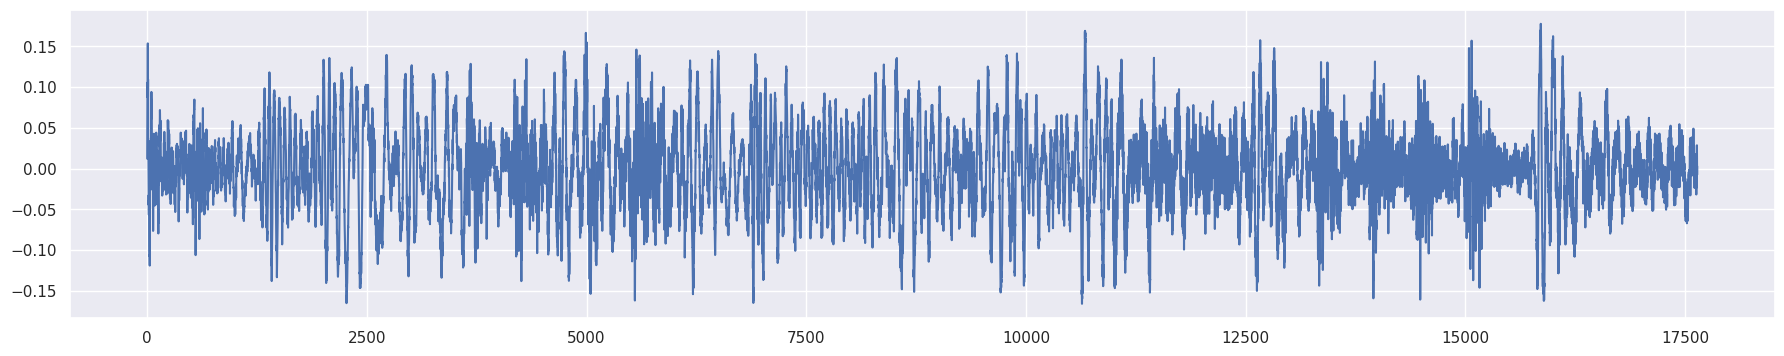

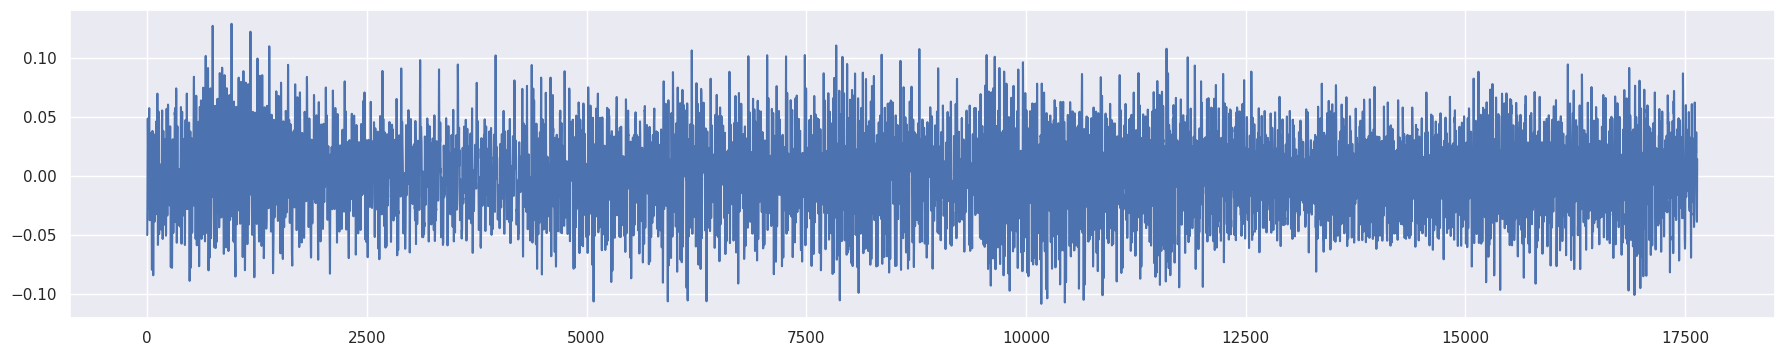

In [7]:
# 7. Pad each phrase to the same length using background noise
# Then store the padded phrases in a word array
def phrase_map_to_tagged_words(phrase_map):
    words = []
    for tags, phrases in phrase_map.items():
        for phrase in phrases:
            noise_samples = audio_slice_len - len(phrase)
            noise_slices = np.array(extract_random_slices(background_noise, slice_count=2, total_samples=noise_samples))
            padded_phrase = np.concatenate((noise_slices[0], phrase, noise_slices[1])).squeeze()
            words.append({
                "audio": padded_phrase,
                "tags": tags
            })

    return words

tagged_words = phrase_map_to_tagged_words(phrase_map)
print(len(tagged_words))

# Then do the same for the background sounds (music, noise, vocals etc..)
def track_to_tagged_words(audio, words, tags):
    reshapable_samples = len(audio) // audio_slice_len * audio_slice_len
    reshapable_audio = audio[:reshapable_samples].reshape((-1, audio_slice_len))

    for audio_slice in reshapable_audio:
        words.append({
            "audio": audio_slice,
            "tags": tags
        })

def background_to_tagged_words(background_dict):
    words = []
    rand_amp_min = 0.05
    rand_max_amp = 0.4

    for key, audio in background_dict.items():
        track_to_tagged_words(audio, words, "NOISE")

    track_to_tagged_words(background_noise, words, "BKG")
    return words

bkg_slices = background_to_tagged_words(background_dict)
print(len(bkg_slices))

#Plot some background sounds and play their matching audio
plot_waveform(bkg_slices[100]["audio"])
display(Audio(bkg_slices[100]["audio"], rate=sample_rate))

plot_waveform(bkg_slices[500]["audio"])
display(Audio(bkg_slices[500]["audio"], rate=sample_rate))

In [8]:
#8. Constants used for creating spectrograms
frame_length = 1024 # How many discrete samples in each frame of the stft transform
frame_step = 128 # Overlapping samples between frames; Default librosa value is frame_length // 4
mel_bins = 80 # How many discrete mel filter bands to use when transforming the spectrograms from Hz to Mel scale
spectrogram_bins = (frame_length // 2) #+ 1
lower_edge_hertz = 0.0 #Lowest frequency to capture in spectrograms (will trim + stretch the result accordingly)
upper_edge_hertz = 4410.0 #Highest frequency to capture in spectrograms (will trim + stretch the result accordingly)
max_amplitude = 80.0 #Upper bound for decibel calculations. Affects intensity of spectrograms (decibels are not an absolute unit, they are calculated w.r.t a range of values)

# Convert a waveform array to a spectrogram, using the short-time fourier transform (a discrete variant which overlaps signal edges)
def librosa_spectrogram(waveform):
    spectrogram = librosa.stft(
        waveform,
        n_fft=frame_length,
        hop_length=frame_step
    )

    spectrogram = np.abs(spectrogram)
    return spectrogram

spectrogram = librosa_spectrogram(tagged_words[0]["audio"])
print(spectrogram.shape)
spectrogram # shape=(frame_length / 2 + 1, fft_unique_bins + 1), interpreted as (hz/shape[0] increments, timestamp)

(513, 138)


array([[9.4591478e-06, 8.0628498e-03, 2.1215817e-02, ..., 8.5101947e-03,
        8.3263572e-03, 4.4443812e-03],
       [8.9559285e-03, 1.5412922e-02, 2.3365594e-02, ..., 1.0000257e-02,
        1.2483971e-02, 1.2245786e-02],
       [1.8831922e-02, 2.5652276e-02, 1.8721644e-02, ..., 9.9278707e-03,
        1.5759626e-02, 1.8253874e-02],
       ...,
       [5.9255899e-04, 3.2923993e-04, 4.9847231e-04, ..., 7.0696260e-04,
        1.0352061e-03, 1.1290745e-03],
       [1.2361959e-03, 1.2903743e-03, 1.3970784e-03, ..., 9.5559185e-04,
        1.1501409e-03, 1.0214106e-03],
       [1.6991399e-03, 2.2142765e-03, 2.3454572e-03, ..., 1.0588759e-03,
        1.0935771e-03, 7.9150789e-04]], dtype=float32)

<ipython-input-9-541a93eca9ef>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return hz.astype(np.int)


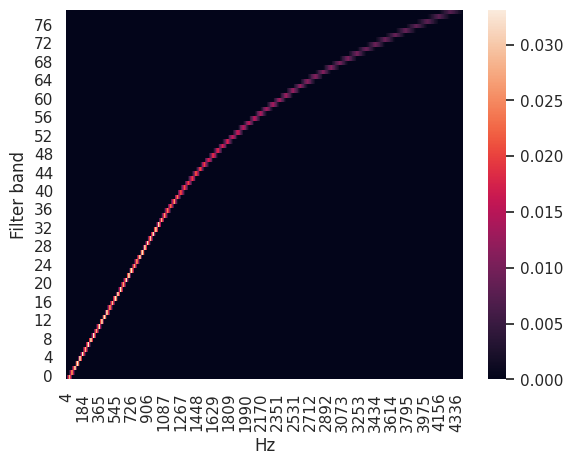

In [9]:
#9.Convert the given number range to frequency units (in hz), within the rane (0, upper_bound)
def range_to_hz(upper_bound, ticks):
    sample_increment = sample_rate / upper_bound
    hz = sample_increment * ticks
    return hz.astype(np.int)

#Convert the given number range to frequency units (in mel pitch), within the rane (0, upper_bound)
def range_to_mels(upper_bound, ticks):
    sample_increment = sample_rate / upper_bound
    hz = sample_increment * ticks
    mel_pitch = 1127 * np.log(1 + hz/700)
    return mel_pitch.astype(np.int)

#Plot a spectrogram array using a seaborn heat map
def plot_spectrogram(spectrogram, color="db", y_scale="mel", figsize=(4, 8), **kwargs):
    print(spectrogram.shape)
    fig = plt.figure(figsize=figsize)
    ax = sns.heatmap(spectrogram, cbar_kws={'label': color}, **kwargs)
    ax.invert_yaxis()

    if y_scale == "hz":
        ax.set_yticklabels(range_to_hz(spectrogram.shape[0], ax.get_yticks()))
        ax.set(xlabel='Time (sample)', ylabel='Hz')
    else:
        ax.set_yticklabels(range_to_mels(spectrogram.shape[0], ax.get_yticks()))
        ax.set(xlabel='Time (sample)', ylabel='Mel')

    plt.show()

# Generate the mel transformation matrix, used for converting to mel scale
def generate_librosa_mel_filterbank():
    return librosa.filters.mel(
        sr=sample_rate,
        n_fft=frame_length,
        n_mels = mel_bins,
        fmin=lower_edge_hertz,
        fmax=upper_edge_hertz
    )

#Construct a mel-scale filter matrix and plot it
mel_filterbank = generate_librosa_mel_filterbank()
ax = sns.heatmap(mel_filterbank)
ax.set(xlabel='Hz', ylabel='Filter band')
ax.set_xticklabels(range_to_hz(mel_filterbank.shape[1] * 2, ax.get_xticks()))
ax.invert_yaxis()

In [10]:
#10
#Calculates the element-wise base-10 logarithm of an array, using logarithm rules + natural logarithm
def elem_wise_log_10(x):
    numerator = np.log(x)
    denominator = np.log(10.0)
    return numerator / denominator

#Convert the amplitude data to decibel data, based on the maximum amplitude allowed for the original spectrogram
def tensor_amplitude_to_decibels(amplitudes, min_clipping = 1e-10):
    power = np.float_power(amplitudes, 2)
    clipped_power = np.maximum(min_clipping, power)

    decibels = 10 * (elem_wise_log_10(clipped_power) - elem_wise_log_10(max_amplitude))
    max_decibel = np.amax(decibels)
    return np.maximum(decibels, max_decibel-max_amplitude)

#Convert the linear audio spectrogram to mel-scale, by multiplying it with the filter matrix
#then apply the log-10 and amplitude-to-db conversions

mel_spectrogram = mel_filterbank @ spectrogram
log_mel_spectrogram = tensor_amplitude_to_decibels(mel_spectrogram)
#plot_spectrogram(log_mel_spectrogram, figsize=(12, 6))

#Calculate the mel spectrogram for any audio slice
def audio_to_log_mel_spectrogram(audio_slice):
    spectrogram = librosa_spectrogram(audio_slice)
    mel_spectrogram = mel_filterbank @ spectrogram
    log_mel_spectrogram = tensor_amplitude_to_decibels(mel_spectrogram)
    return log_mel_spectrogram

#Converts the waveform in a tagged word map to spectrograms
def create_tagged_spectrograoms(tagged_words_map):
    spectrograms = []
    for entry in tagged_words_map:
        spectrograms.append({
            "spectrogram": audio_to_log_mel_spectrogram(entry["audio"]),
            "tags": entry["tags"]
        })

    return spectrograms

tagged_spectrograms = create_tagged_spectrograoms(tagged_words)
print(len(tagged_spectrograms))

bkg_spectrograms = create_tagged_spectrograoms(bkg_slices)
print(len(bkg_spectrograms))

764
2166


In [11]:
#11
def train_test_split(tagged_spectrograms, size_ratio=10):
    train_set = []
    test_set = []

    for idx, sample in enumerate(tagged_spectrograms):
        if idx % size_ratio == 0:
            test_set.append(sample)
        else:
            train_set.append(sample)
    
    return train_set, test_set

tagged_train_spectrograms, tagged_test_spectrograms = train_test_split(tagged_spectrograms)
bkg_train_spectrograms, bkg_test_spectrograms = train_test_split(bkg_spectrograms)

train_set = tagged_train_spectrograms + bkg_train_spectrograms
test_set = tagged_test_spectrograms + bkg_test_spectrograms

print(len(train_set))
print(len(test_set))

#Persist the data to the given file path, in pickle format
def save_to_disk(data, file_path):
    save_file = open(file_path, "wb")
    pickle.dump(data, save_file)
    save_file.close()

#Around 140MB of binary data, make sure you have the storage space :)
save_to_disk(train_set, colab_data + "hebrew_speech_train")
save_to_disk(test_set, colab_data + "hebrew_speech_test")

2636
294


spectrogram augmentation based on https://arxiv.org/pdf/1904.08779.pdf

In [ ]:
"""
extract (f, t) = (filters, timestamps) from the input spectrogram shape
w: defines a uniform distribution between (0, w), and draws a random number w0 from that distribution 
we then draw another random number w1 from the uniform distribution (0, t-w)

a flow field is constructed by using 6 control points: the four corners of the spectrogram, and the vertical mid-points between the left and right corners, respectively
a second flow field is made as a copy of the first

we add a final control point to the source field, at (f//2, w1)
and a final control point to the target field, at (f//2, w1 - w0)

and warp the image by performing spline interpolation between the source and target fields
the result is a nonlinear distortion to the spectrogram along the time axis.
"""
def random_warp(spectrogram, w=40.0):
    filters, timestamps = spectrogram.shape
    median_filter = filters // 2
    w0 = np.random.uniform(0.0, w)
    w1 = np.random.uniform(0.0, timestamps - w)

    as_tensor = tf.constant(spectrogram, shape=[1] + list(spectrogram.shape) + [1], dtype=tf.float32)
    src_points = tf.constant([[
        (median_filter, 0),
        (median_filter, w1),
        (median_filter, timestamps)
    ]], dtype=tf.float32)
    dest_points = tf.constant([[
        (median_filter, 0),
        (median_filter, w1 - w0),
        (median_filter, timestamps)
    ]], dtype=tf.float32)

    warped_tensor, flow_field = sparse_image_warp(
        image=as_tensor,
        source_control_point_locations=src_points,
        dest_control_point_locations=dest_points,
        num_boundary_points=4
    )

    return warped_tensor[0, :, :, 0].numpy()


(80, 138)


<ipython-input-10-4aba94ec3298>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mel_pitch.astype(np.int)


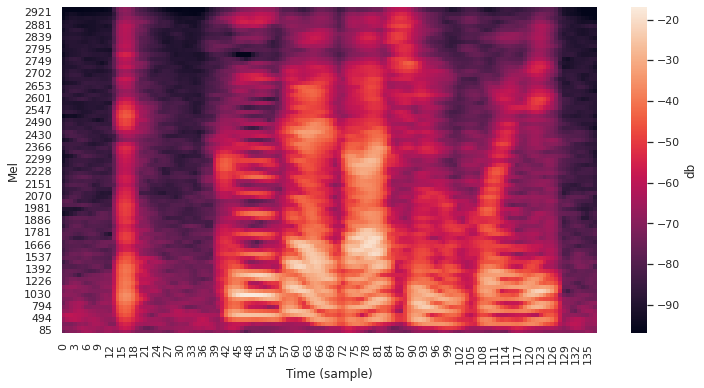

(80, 138)


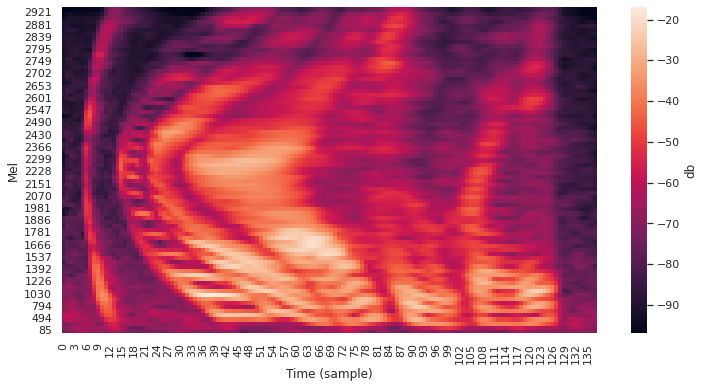

In [ ]:
ab = log_mel_spectrogram
warped_ab = random_warp(ab)
plot_spectrogram(ab, figsize=(12, 6))
plot_spectrogram(warped_ab, figsize=(12, 6))

In [ ]:
# Mask a randomly selected frequency range, across all timestamps
def time_masking(spectrogram, h=15, in_place=False):
    filters, timestamps = spectrogram.shape
    mask_height = np.random.randint(0, h)
    lower_bound = np.random.randint(0, filters - mask_height)
    upper_bound = lower_bound + mask_height

    masked_copy = spectrogram if in_place else np.copy(spectrogram)
    masked_copy[lower_bound:upper_bound,:] = np.amin(masked_copy)
    return masked_copy

(80, 138)


<ipython-input-10-4aba94ec3298>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mel_pitch.astype(np.int)


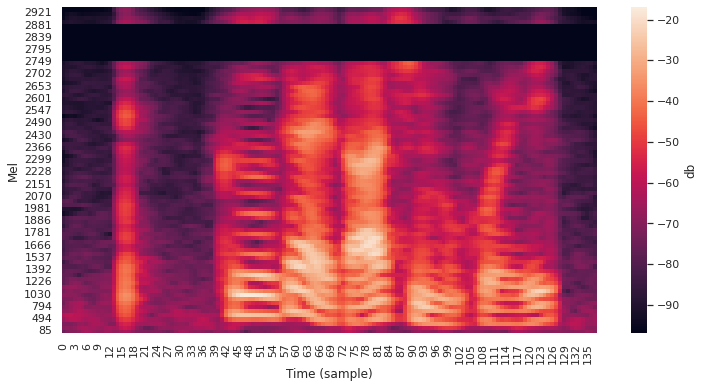

In [ ]:
masked_ab = time_masking(ab)
plot_spectrogram(masked_ab, figsize=(12, 6))

In [ ]:
# Mask a randomly selected range of samples, across all frequencies
def frequency_masking(spectrogram, w=25, in_place=False):
    filters, timestamps = spectrogram.shape
    mask_width = np.random.randint(0, w)
    left_bound = np.random.randint(0, timestamps - mask_width)
    right_bound = left_bound + mask_width

    masked_copy = spectrogram if in_place else np.copy(spectrogram)
    masked_copy[:, left_bound:right_bound] = np.amin(masked_copy)
    return masked_copy

(80, 138)


<ipython-input-10-4aba94ec3298>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mel_pitch.astype(np.int)


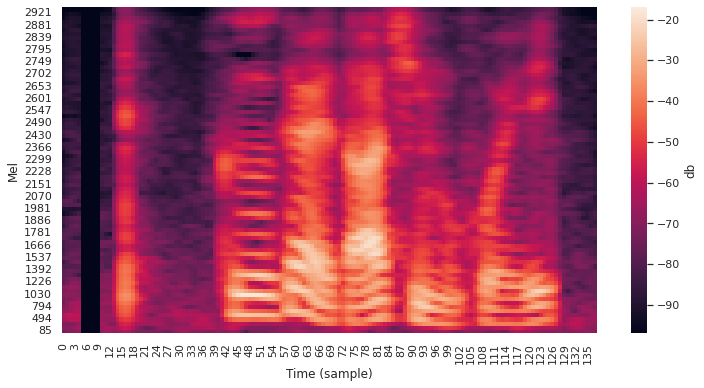

In [ ]:
masked_ab = frequency_masking(ab)
plot_spectrogram(masked_ab, figsize=(12, 6))

In [ ]:
#Apply all masks and warps in succession to the given spectrogram
def mask_and_warp(spectrogram, in_place=False, *args, **kwargs):
    warped = random_warp(spectrogram, *args, **kwargs)
    time_masked = time_masking(warped, in_place=in_place, *args, **kwargs)
    return time_masked
    # freq_masked = frequency_masking(time_masked, in_place=in_place, *args, **kwargs)
    # return freq_masked

(80, 138)


<ipython-input-10-4aba94ec3298>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mel_pitch.astype(np.int)


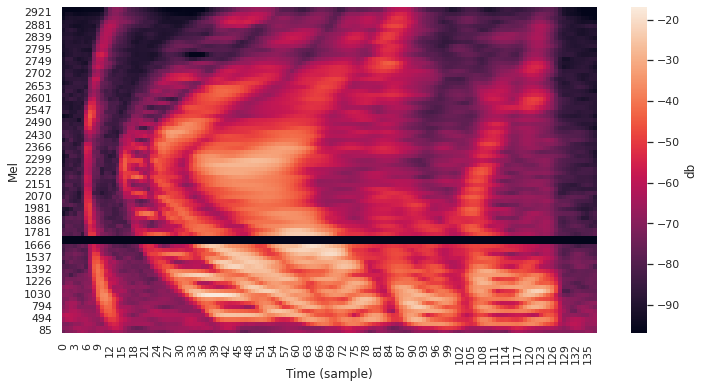

In [ ]:
augmented_ab = mask_and_warp(ab)
plot_spectrogram(augmented_ab, figsize=(12, 6))

In [ ]:
#Randomly augment the entire dataset x {repeats} times
def repeat_and_augment(tagged_spectrograms, repeats):
    repeated_spectrograms = []
    for i in range(repeats):
        repeated_spectrograms += copy.deepcopy(tagged_spectrograms)

    for entry in repeated_spectrograms:
        entry["spectrogram"] = mask_and_warp(entry["spectrogram"], in_place=True)

    return repeated_spectrograms

In [ ]:
augmented_train_set = repeat_and_augment(train_set, 2)
augmented_test_set = repeat_and_augment(test_set, 2)
print(len(repeated_spectrograms))

NameError: ignored

(80, 138)


<ipython-input-10-4aba94ec3298>:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return mel_pitch.astype(np.int)


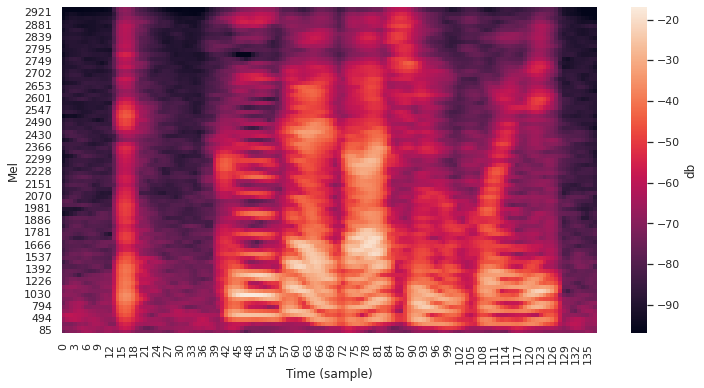

(80, 138)


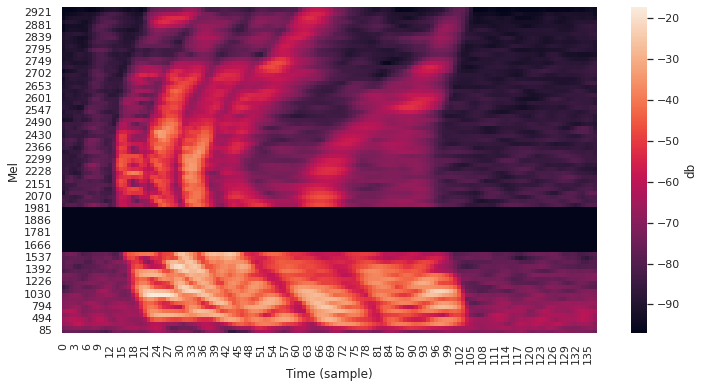

(80, 138)


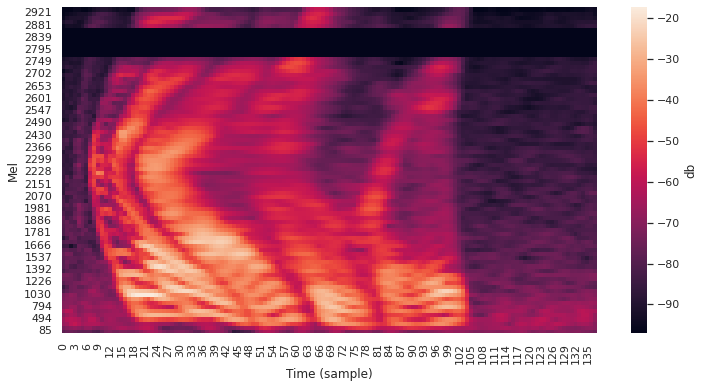

In [ ]:
#Verify that copies of the same spectrograms are independent and augmented...
plot_spectrogram(tagged_spectrograms[0]["spectrogram"], figsize=(12, 6))
plot_spectrogram(augmented_train_set[0]["spectrogram"], figsize=(12, 6))
plot_spectrogram(augmented_train_set[len(train_set)]["spectrogram"], figsize=(12, 6))

In [ ]:
#...While having the same tags
print(augmented_train_set[0]["tags"])
print(augmented_train_set[len(train_set)]["tags"])

ge1_gai4_da2_qing3_hui2
ge1_gai4_da2_qing3_hui2


In [ ]:
save_to_disk(augmented_train_set, colab_data + "hebrew_speech_train")
save_to_disk(augmented_test_set, colab_data + "hebrew_speech_test")